In [1]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 10.2 MB/s eta 0:00:00


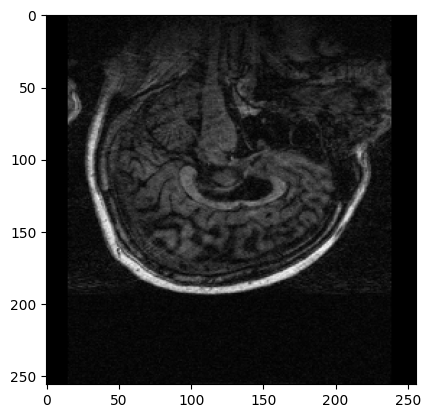

In [ ]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Ruta a tu archivo NIfTI (.hdr o .img) dentro de Google Drive
nifti_path = '/content/RAW/mpr-3.nifti.hdr'


# Cargar la imagen NIfTI
image = sitk.ReadImage(nifti_path)

# Convertir a array para visualización
image_array = sitk.GetArrayFromImage(image)

# Mostrar la imagen, seleccionando una rebanada específica (por ejemplo, la número 50)
plt.imshow(image_array[63, :, :], cmap='gray')
plt.show()


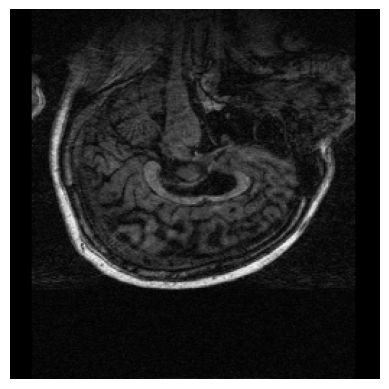

In [ ]:
plt.imshow(image_array[63, :, :], cmap='gray')
plt.axis('off')  # Para quitar los ejes
plt.savefig('/content/corte_64.png', bbox_inches='tight', pad_inches=0)
plt.show()


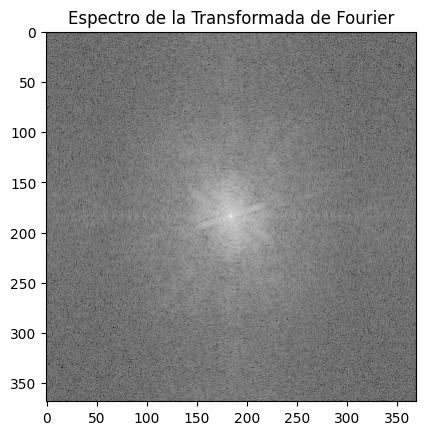

In [ ]:
import numpy as np
from PIL import Image

imagen = Image.open('/content/corte_64.png')


array = np.array(imagen)
if array.ndim == 3 and array.shape[2] >= 3:
    arrayGris = np.dot(array[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
else:
    arrayGris = array

imagenGris = (arrayGris // 15) * 15


# Aplicar la Transformada de Fourier 2D
fourier = np.fft.fft2(imagenGris)
# Shift para desplazar las frecuencias bajas al centro del espectro
fourierShift = np.fft.fftshift(fourier)

# Calcular el espectro de magnitudes y Log para comprimir los valores (ayuda a manejar la amplia gama de valores en el espectro)
espectro = np.log(np.abs(fourierShift) + 1)

plt.imshow(espectro, cmap='gray')
plt.title('Espectro de la Transformada de Fourier')
plt.show()

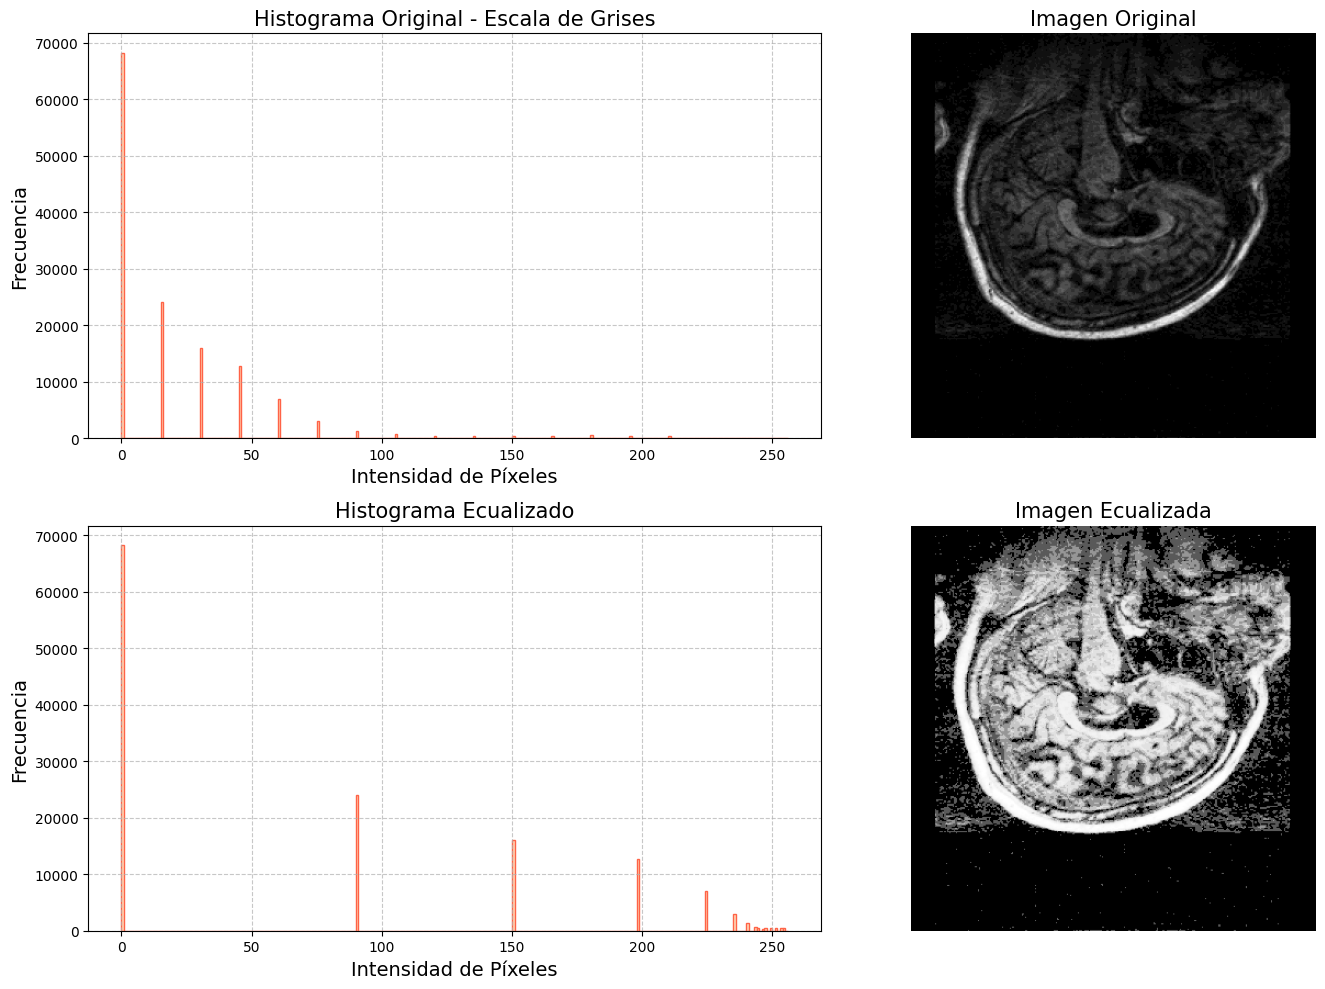

In [ ]:
# Función para ecualización del histograma
def ecualizar_histograma(imagen):
    # Calcular el histograma
    histograma, bins = np.histogram(imagen.flatten(), bins=256, range=[0,256])

    # Calcular el histograma acumulado (CDF)
    cdf = histograma.cumsum()

    # Normalizar el CDF para que sus valores estén entre 0 y 255
    cdf_normalizado = 255 * (cdf - cdf.min()) / (cdf.max() - cdf.min())

    # Aplicar la transformación de ecualización
    imagen_ecualizada = np.interp(imagen.flatten(), bins[:-1], cdf_normalizado)

    return imagen_ecualizada.reshape(imagen.shape)

# Aplicar la ecualización del histograma
imagen_ecualizada = ecualizar_histograma(imagenGris)

# Visualizar los histogramas y las imágenes
plt.figure(figsize=(15, 10))

# Histograma de la imagen original
plt.subplot(2, 2, 1)
plt.title('Histograma Original - Escala de Grises', fontsize=15)
plt.hist(imagenGris.ravel(), bins=256, range=(0, 256), color='peachpuff', edgecolor='tomato')
plt.xlabel('Intensidad de Píxeles', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Imagen original
plt.subplot(2, 2, 2)
plt.title("Imagen Original", fontsize=15)
plt.imshow(imagenGris, cmap='gray')
plt.axis('off')

# Histograma de la imagen ecualizada
plt.subplot(2, 2, 3)
plt.title('Histograma Ecualizado', fontsize=15)
plt.hist(imagen_ecualizada.ravel(), bins=256, range=(0, 256), color='peachpuff', edgecolor='tomato')
plt.xlabel('Intensidad de Píxeles', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Imagen ecualizada
plt.subplot(2, 2, 4)
plt.title("Imagen Ecualizada", fontsize=15)
plt.imshow(imagen_ecualizada, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


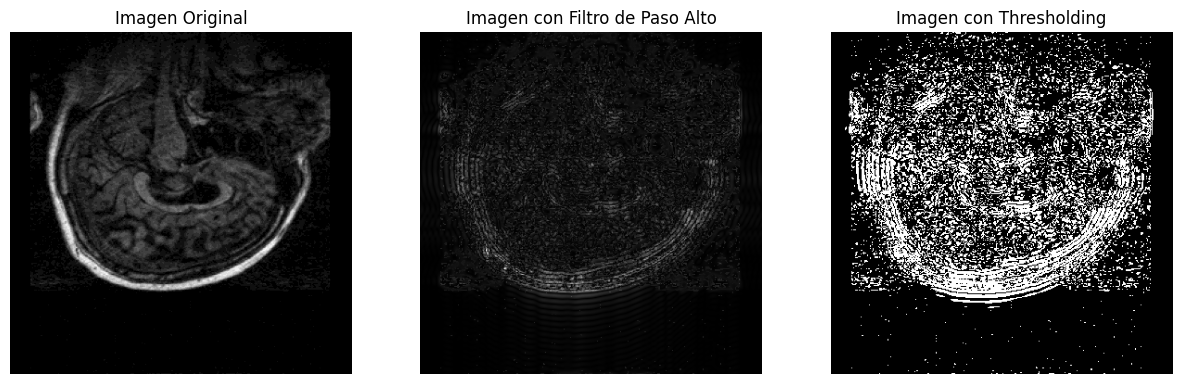

In [ ]:
# Aplicar la Transformada de Fourier 2D
fourier = np.fft.fft2(imagenGris)
fourier_shifted = np.fft.fftshift(fourier)

# Crear un filtro de paso alto (matriz con 0 en las frecuencias bajas y 1 en las altas)
filas, columnas = imagenGris.shape
centro_filas, centro_columnas = filas // 2, columnas // 2
radio = 30  # Radio para definir las frecuencias bajas

# Crear una máscara circular de paso alto
filtro_paso_alto = np.ones((filas, columnas))
filtro_paso_alto[centro_filas-radio:centro_filas+radio, centro_columnas-radio:centro_columnas+radio] = 0

# Aplicar el filtro al espectro
espectro_filtrado = fourier_shifted * filtro_paso_alto

# Transformada inversa para volver al dominio espacial
espectro_inverso = np.fft.ifftshift(espectro_filtrado)
imagen_filtrada = np.fft.ifft2(espectro_inverso)
imagen_filtrada = np.abs(imagen_filtrada)

# Aplicar thresholding para resaltar los bordes
umbral =   # Puedes ajustar este valor según el nivel de detalle que desees
imagen_threshold = np.where(imagen_filtrada > umbral, 255, 0)  # Imagen binaria

# Mostrar la imagen original, filtrada y con thresholding
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(imagenGris, cmap='gray')
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(imagen_filtrada, cmap='gray')
plt.title("Imagen con Filtro de Paso Alto")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(imagen_threshold, cmap='gray')
plt.title("Imagen con Thresholding")
plt.axis('off')

plt.show()

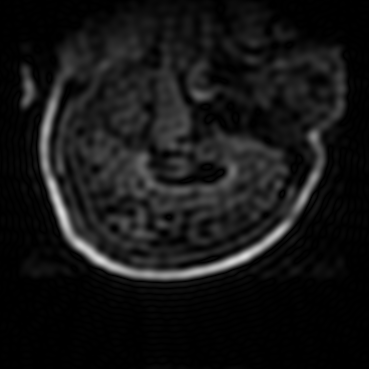

In [ ]:
imagenFinal = Image.fromarray(imagenFiltrada.astype(np.uint8))
imagenFinal

AttributeError: 'list' object has no attribute 'flatten'

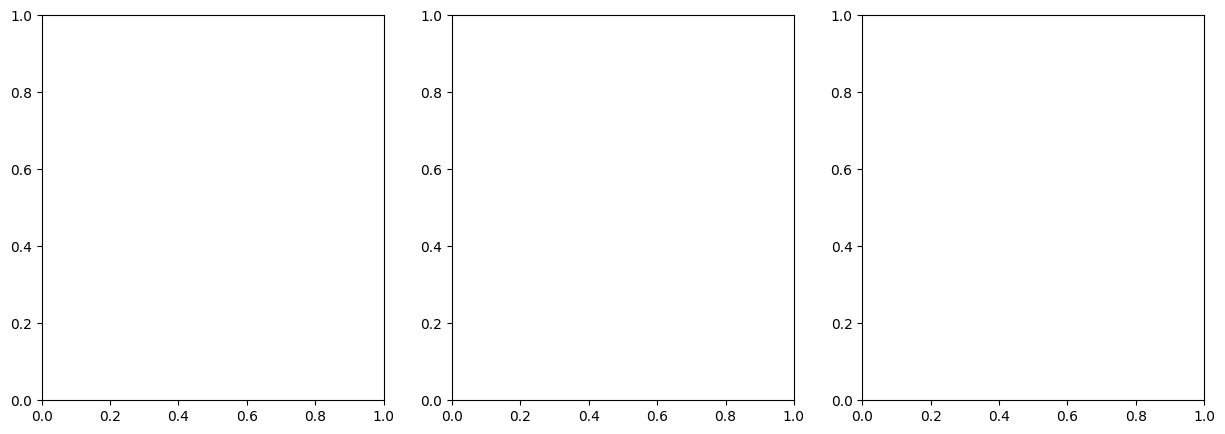

In [ ]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import math

# Ruta local de tu carpeta donde están los archivos NIfTI
nifti_folder = '/content/RAW'

# Listar todos los archivos con extensiones .img o .hdr en el directorio
nifti_files = [f for f in os.listdir(nifti_folder) if f.endswith(('.img', '.hdr'))]

# Número de archivos NIfTI
num_files = len(nifti_files)

# Definir el número de columnas por fila
num_columns = 3
# Calcular el número de filas necesario
num_rows = math.ceil(num_files / num_columns)

# Crear una figura con subplots en una cuadrícula (num_rows x num_columns)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Si hay solo una fila, 'axes' no es una lista de listas, así que lo convertimos en una lista de listas
if num_rows == 1:
    axes = [axes]

# Aplanar los ejes en una lista para iterar más fácilmente si hay múltiples filas
axes = axes.flatten()

# Iterar sobre los archivos NIfTI y mostrarlos
for ax, nifti_file in zip(axes, nifti_files):
    nifti_path = os.path.join(nifti_folder, nifti_file)

    # Cargar la imagen NIfTI usando SimpleITK
    image = sitk.ReadImage(nifti_path)

    # Convertir a array para visualización
    image_array = sitk.GetArrayFromImage(image)

    # Mostrar una rebanada de la imagen (se elige la rebanada central)
    slice_index = image_array.shape[0] // 2
    ax.imshow(image_array[slice_index, :, :], cmap='gray')
    ax.set_title(f'File: {nifti_file} - Slice {slice_index}')
    ax.axis('off')  # Ocultar los ejes para una visualización más limpia

# Desactivar cualquier subplot extra si hay menos imágenes que subplots
for i in range(num_files, len(axes)):
    axes[i].axis('off')

# Ajustar el espaciado para que no se solapen los títulos y las imágenes
plt.tight_layout()
plt.show()
